In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2020-05-07 16:55:54.464464


In [2]:
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from datasets.lab6.imresize import imresize
import numpy as np
import skimage
import os
import glob
from skimage.io import imread
import skimage

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:

T91_directory = "./datasets/lab6/T91/"
T91_images = sorted(glob.glob(T91_directory + "*.png"))

print("The number of training images : ",len(T91_images))

# Augmentation setting
SCALE = [1, 0.9, 0.8, 0.7, 0.6, 2]
ROTATION = [0,1,2,3]
FLIP = [True,False]
PATCH_SIZE = 64
STRIDE = 64
IS_GRAY = True
HR_SET = []

def load_img(filepath, is_gray):
    img = imread(filepath)
    ch = img.ndim
    if ch == 2:
        img = skimage.color.gray2rgb(img)
    if is_gray:    
        img = skimage.color.rgb2ycbcr(img)
    return img / 255.

for idx in range(len(T91_images)):
    print("\r Processing ", idx+1," / ",len(T91_images), end = '')
    image_directory = T91_images[idx]
    for f in FLIP:
        for r in ROTATION:
            for s in SCALE:
                 # load image
                image = load_img(image_directory, IS_GRAY) # is_gary : YCbCr or RGB
                 # flipping
                if f:
                    image = np.fliplr(image)
                 # rotation
                image = np.rot90(image, k=r, axes=(0,1))
                 # scaling
                image = imresize(image, scalar_scale = s)
                image = image.clip(0,1)
                # generate HR patch
                h,w,_ = image.shape
                for i in range(0, h-PATCH_SIZE, STRIDE):
                    for j in range(0, w-PATCH_SIZE, STRIDE):
                        hr_patch = image[i:i+PATCH_SIZE, j:j+PATCH_SIZE, :]
                        if IS_GRAY:
                            hr_patch = hr_patch[:,:,0]
                        HR_SET.append(hr_patch)

print("\nThe number of training patches : ",len(HR_SET))
np.save('./datasets/lab6/HR_patches_from_T91.npy', HR_SET)
print("Training patches are successfully saved")


The number of training images :  91
 Processing  91  /  91
The number of training patches :  60456


PermissionError: [Errno 13] Permission denied: './datasets/lab6/HR_patches_from_T91.npy'

In [3]:
print('STEP 1: DEFINE DATASET')

class T91_images(Dataset):
    def __init__(self, data_dir = "./datasets/lab6/HR_patches_from_T91.npy", HR_patch_size = 64, scale_factor = 4):
        super(T91_images, self).__init__()
        self.HR_patches_np = np.load(data_dir) # pre-processed patches
        self.HR_patch_size = HR_patch_size
        self.scale_factor = scale_factor
        
    def __getitem__(self, idx):
        HR_patch_np = self.HR_patches_np[idx] # high resolution patch
        LR_patch_np = imresize(HR_patch_np, scalar_scale = 1.0 / self.scale_factor) # low resolution patch
        BC_patch_np = imresize(LR_patch_np, scalar_scale = self.scale_factor) # bicubic upsampled patch
        
        HR_patch = torch.from_numpy(HR_patch_np).type(torch.FloatTensor)
        LR_patch = torch.from_numpy(LR_patch_np).type(torch.FloatTensor)
        BC_patch = torch.from_numpy(BC_patch_np).type(torch.FloatTensor)
        
        HR_patch = HR_patch.unsqueeze(0) # size : 1(c) x 64(h) x 64(w)
        LR_patch = LR_patch.unsqueeze(0) # size : 1(c) x 16(h) x 16(w)
        BC_patch = BC_patch.unsqueeze(0) # size : 1(c) x 64(h) x 64(w)
                                
        return HR_patch, LR_patch, BC_patch # Y-channel patches
    
    def __len__(self):
        return len(self.HR_patches_np)
    
class Set5(Dataset):
    def __init__(self, data_dir = './datasets/lab6/Set5/', scale_factor=4):
        super(Set5, self).__init__()
        self.image_filenames = [os.path.join(data_dir, x) for x in sorted(os.listdir(data_dir))]
        self.scale_factor = scale_factor

    def load_img(self, filepath):
        img = skimage.io.imread(filepath)
        ch = img.ndim
        if ch == 2:
            img = skimage.color.gray2rgb(img)
        img = skimage.color.rgb2ycbcr(img)

        return img / 255.
    
    def calculate_valid_crop_size(self, crop_size, scale_factor):
        return crop_size - (crop_size % scale_factor)
    
    def __getitem__(self, idx):
        # load image
        img_np = self.load_img(self.image_filenames[idx])
        
        # original HR image size
        h, w, _ = img_np.shape
                
        # determine valid HR image size with scale factor
        HR_img_w = self.calculate_valid_crop_size(w, self.scale_factor)
        HR_img_h = self.calculate_valid_crop_size(h, self.scale_factor)

        # determine lr_img LR image size
        LR_img_w = HR_img_w // self.scale_factor
        LR_img_h = HR_img_h // self.scale_factor

        HR_img_np = img_np[:HR_img_h,:HR_img_w,:] # high resolution image
        LR_img_np = imresize(HR_img_np, scalar_scale = 1.0/self.scale_factor) # low resolution image
        BC_img_np = imresize(LR_img_np, scalar_scale = self.scale_factor) # bicubic upsampled image
        
        HR_img = torch.from_numpy(HR_img_np).type(torch.FloatTensor).permute(2,0,1) # size : 3(c) x h x w
        LR_img = torch.from_numpy(LR_img_np).type(torch.FloatTensor).permute(2,0,1) # size : 3(c) x (h/scale_factor) x (w/scale_factor)
        BC_img = torch.from_numpy(BC_img_np).type(torch.FloatTensor).permute(2,0,1) # size : 3(c) x h x w
        
        return HR_img, LR_img, BC_img # YCbCr images

    def __len__(self):
        return len(self.image_filenames)

STEP 1: DEFINE DATASET


In [4]:
print('STEP 2: LOADING DATASET')

scale_factor = 4 # 1/4 down scaling

train_dataset = T91_images(data_dir = "./datasets/lab6/HR_patches_from_T91.npy", HR_patch_size = 64, scale_factor = scale_factor)
test_dataset = Set5(data_dir = "./datasets/lab6/Set5/", scale_factor = scale_factor)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, 
                                           batch_size = 64, 
                                           shuffle = True, num_workers = 4)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, 
                                          batch_size = 1, 
                                          shuffle = False)

STEP 2: LOADING DATASET


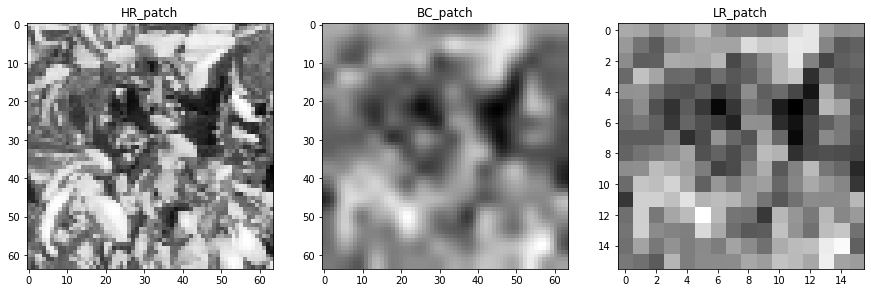

In [5]:
(HR_patch, LR_patch, BC_patch) = train_dataset[400]
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
ax1.imshow(HR_patch.squeeze(0).numpy(), cmap='gray')
ax1.set_title("HR_patch")
ax2.imshow(BC_patch.squeeze(0).numpy(), cmap='gray')
ax2.set_title("BC_patch")
ax3.imshow(LR_patch.squeeze(0).numpy(), cmap='gray')
ax3.set_title("LR_patch")
plt.show()

In [6]:
print('STEP 3: CREATE MODEL CLASS (FSRCNN)')

class FSRCNN(nn.Module):
    def __init__(self, scale_factor = 4):
        super(FSRCNN, self).__init__()
        #############
        # CODE HERE #
        #############        
        # Feature extraction
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(1, 56, 5, padding = 2 ),
            nn.PReLU()
        )
        
        # shrinking
        self.shrinking = nn.Sequential(
            nn.Conv2d(56, 12, 1),
            nn.PReLU()
        )
        
        # non-linear mapping
        self.non_lin_mapping = nn.Sequential(
            nn.Conv2d(12, 12, 3, padding = 1),
            nn.PReLU(),
            nn.Conv2d(12, 12, 3, padding = 1),
            nn.PReLU(),
            nn.Conv2d(12, 12, 3, padding = 1),
            nn.PReLU(),
            nn.Conv2d(12, 12, 3, padding = 1),
            nn.PReLU()

        )
        
        # expanding
        self.expanding = nn.Sequential(
            nn.Conv2d(12, 56, 1),
            nn.PReLU()
        )
        
        # deconv
        self.deconvolution = nn.ConvTranspose2d(56, 1, 9, stride=4, padding=3,output_padding=1)
            
    def weight_init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, mean = 0.0, std = 0.02)
#                 nn.init.kaiming_normal_(m.weight.data, a=0.25) # for SGD
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight.data, mean = 0.0, std = 0.001)
                if m.bias is not None:
                    m.bias.data.zero_()
    
    
    def forward(self, LR_patch):
        x = self.feature_extraction(LR_patch)
        x = self.shrinking(x)
        x = self.non_lin_mapping(x)
        x = self.expanding(x)
        output = self.deconvolution(x)
        return output

STEP 3: CREATE MODEL CLASS (FSRCNN)


In [7]:
print('STEP 4: INSTANTIATE MODEL CLASS')


model = FSRCNN(scale_factor = scale_factor)
model.weight_init()
num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)

#######################
#  USE GPU FOR MODEL  #
#######################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  12644


FSRCNN(
  (feature_extraction): Sequential(
    (0): Conv2d(1, 56, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): PReLU(num_parameters=1)
  )
  (shrinking): Sequential(
    (0): Conv2d(56, 12, kernel_size=(1, 1), stride=(1, 1))
    (1): PReLU(num_parameters=1)
  )
  (non_lin_mapping): Sequential(
    (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): PReLU(num_parameters=1)
    (4): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): PReLU(num_parameters=1)
    (6): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): PReLU(num_parameters=1)
  )
  (expanding): Sequential(
    (0): Conv2d(12, 56, kernel_size=(1, 1), stride=(1, 1))
    (1): PReLU(num_parameters=1)
  )
  (deconvolution): ConvTranspose2d(56, 1, kernel_size=(9, 9), stride=(4, 4), padding=(3, 3), output_padding=(1, 1))
)

In [8]:
print('STEP 5: INSTANTIATE OPTIMIZER CLASS')

lr_conv = 1e-3
lr_deconv = 1e-4
# momentum = 0.9

param_conv = list(model.feature_extraction.parameters())+\
             list(model.shrinking.parameters())+\
             list(model.non_lin_mapping.parameters())+\
             list(model.expanding.parameters())

param_deconv = model.deconvolution.parameters()

# optimizer = torch.optim.SGD([{'params':param_conv},
#                              {'params':param_deconv, 'lr':lr_deconv}],
#                              lr = lr_conv, momentum = momentum)

optimizer = torch.optim.Adam([{'params':param_conv},
                             {'params':param_deconv, 'lr':lr_deconv}],
                             lr = lr_conv)

STEP 5: INSTANTIATE OPTIMIZER CLASS


### 1.2 Train the FSRCNN model and print PSNR for every epochs [4 points]

In [11]:
import time
print('STEP 6: INSTANTIATE LOSS CLASS')
#############
criterion = nn.MSELoss()
#############

print('STEP 7: TRAIN THE MODEL')

if not os.path.exists("./weights/"):
    os.mkdir("./weights/")

if not os.path.exists("./weights/lab6/"):
    os.mkdir("./weights/lab6/")

num_epochs = 51

def PSNR(pred, gt, s = 0): # input images : 0~1 normalized / s : scale factor
    if pred.is_cuda:
        pred = pred.cpu()
    if gt.is_cuda:
        gt = gt.cpu()
    pred = pred[:,:,s:-s,s:-s] # shave border
    gt = gt[:,:,s:-s,s:-s]
    pred = pred.clamp(0, 1)
    diff = pred - gt
    mse = np.mean(diff.numpy() ** 2)
    if mse == 0:
        return 100
    return 10 * np.log10(1.0 / mse)

for epoch in range(num_epochs):
    # training stage
    model.train()
    total_loss = 0
    start = time.time()
    for i, (HR_patch, LR_patch, BC_patch) in enumerate(train_loader):
        #############
        hr = HR_patch.to(device)
        lr = LR_patch.to(device)
        
        optimizer.zero_grad()
        
        output = model(lr)
        loss = criterion(output, hr)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    print('epoch : %d    average_loss : %f'%(epoch, total_loss/(i+1)))
        #############
        
    # test stage
    end = time.time()
    model.eval()
    total_psnr = 0
    total_psnr_bic = 0
    # Iterate through test dataset
    with torch.no_grad():
        for (HR_img, LR_img, BC_img) in test_loader:
            #############
            # delete the residue channel Cb, Cr & restoration the channel dimension
            hr = HR_img.to(device)[:,0,:,:].unsqueeze(1)
            lr = LR_img.to(device)[:,0,:,:].unsqueeze(1)
            bc = BC_img.to(device)[:,0,:,:].unsqueeze(1)
            prediction = model(lr)
            psnr = PSNR(prediction, hr, scale_factor)
            psnr_bic = PSNR(bc, hr, scale_factor)
            
            total_psnr += psnr
            total_psnr_bic += psnr_bic
            print('PSNR: %.4fdB  , PSNR_bic : %.4fdB' %(psnr, psnr_bic))
    
    print('average PSNR: %.4fdB  , average PSNR_bic : %.4fdB' %(total_psnr/5, total_psnr_bic/5))
    print('elapsed time : {}'.format(end - start))
            #############
            
    
    # save weights
    if epoch % 5 == 0 and epoch != 0:
        torch.save({'state_dict':model.state_dict()},'./weights/lab6/checkpoint_%03d.pkl'%(epoch))

STEP 6: INSTANTIATE LOSS CLASS
STEP 7: TRAIN THE MODEL
epoch : 0    average_loss : 0.001449
PSNR: 32.5084dB  , PSNR_bic : 31.8373dB
PSNR: 31.1227dB  , PSNR_bic : 30.1065dB
PSNR: 22.9605dB  , PSNR_bic : 22.1396dB
PSNR: 31.9364dB  , PSNR_bic : 31.6845dB
PSNR: 27.3139dB  , PSNR_bic : 26.4575dB
average PSNR: 29.1684dB  , average PSNR_bic : 28.4451dB
elapsed time : 28.818700551986694
epoch : 1    average_loss : 0.001425
PSNR: 32.5465dB  , PSNR_bic : 31.8373dB
PSNR: 31.1374dB  , PSNR_bic : 30.1065dB
PSNR: 22.9714dB  , PSNR_bic : 22.1396dB
PSNR: 31.9224dB  , PSNR_bic : 31.6845dB
PSNR: 27.3421dB  , PSNR_bic : 26.4575dB
average PSNR: 29.1840dB  , average PSNR_bic : 28.4451dB
elapsed time : 29.129483938217163
epoch : 2    average_loss : 0.001418
PSNR: 32.0412dB  , PSNR_bic : 31.8373dB
PSNR: 31.1178dB  , PSNR_bic : 30.1065dB
PSNR: 22.9519dB  , PSNR_bic : 22.1396dB
PSNR: 31.8039dB  , PSNR_bic : 31.6845dB
PSNR: 27.2710dB  , PSNR_bic : 26.4575dB
average PSNR: 29.0371dB  , average PSNR_bic : 28.4451d

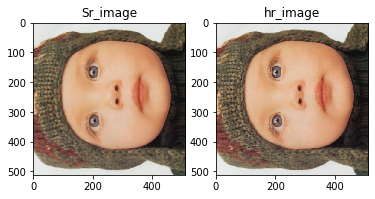

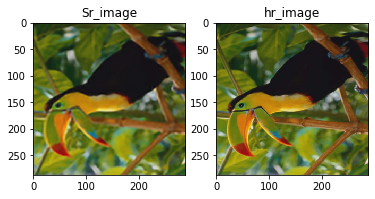

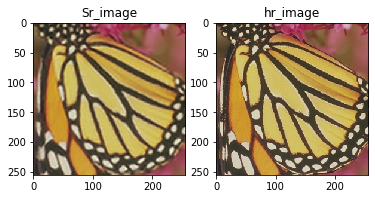

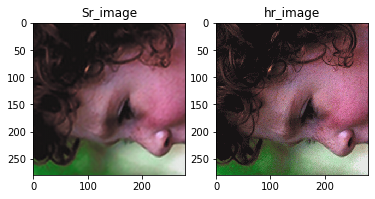

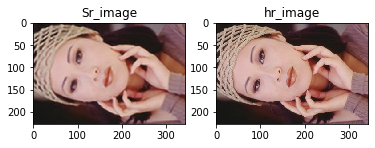

In [12]:
def ycbcr2rgb(im): # input image : ranges from 0 to 255
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.astype(np.float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

trained_weight = torch.load("./weights/lab6/checkpoint_050.pkl")
model.load_state_dict(trained_weight['state_dict'])
model.eval()

with torch.no_grad():
    for (HR_img, LR_img, BC_img) in test_loader:
        #############
        hr = HR_img.squeeze(0)
        # devide by channel 
        lr1 = LR_img.to(device)[:,0,:,:].unsqueeze(1)
        lr2 = LR_img.to(device)[:,1,:,:].unsqueeze(1)
        lr3 = LR_img.to(device)[:,2,:,:].unsqueeze(1)
        # Pass the model for each channel.
        prediction1 = model(lr1)
        prediction2 = model(lr2)
        prediction3 = model(lr3)
        # Put together again.
        prediction = torch.cat((prediction1, prediction2, prediction3), 1)
        # Delete batch dimension and convert for rgb transformation
        prediction = prediction.detach().cpu().numpy().squeeze(0).T
        hr = hr.detach().cpu().numpy().T
        # rgb transformation
        SR_image = ycbcr2rgb(prediction*255)
        hr_image = ycbcr2rgb(hr*255)
        # plot sr_image & original hr_image
        fig = plt.figure()
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)
        ax1.imshow(SR_image)
        ax1.set_title("Sr_image")
        ax2.imshow(hr_image)
        ax2.set_title("hr_image")
        #############

## Discussion & Analysis
> Model construct
>> 해당 Network를 구현하는 부분에 있어서 그나마 가장 큰 어려움은 transformed convolution에 있었다. 그러나 논문과 conv layer를 통과했을 때 output size를 계산하는 식을 통해 값을 정해서 구현하였다. 그 외에 큰 어려움은 없었다.

> training & test
>> training 과 test의 image의 형식이 달라서 dimension설정에 처음에는 어려움이 있었다. unsqueeze를 통해 해결하였다. 성능비교를 하자면 FSRCNN의 PSNR 값이 더 높게 나온 것을 확인할 수 있었다. 평균 수치는 1정도 높은 것을 확인할 수 있었다. 또한, 속도면에서 1epoch를 돌리는 것을 확인해본결과 약 29초 정도로 빠른 속도를 보여주는 것을 확인할 수 있었다.

> Visualize
>> image의 channel마다 Network를 통과시켜주었다. 이를 contate하고 visualize하는 부분에서 dimension설정에서 처음에는 어려움을 겪었다. 이 후 결과를 보면 GT(hr)image와의 비교를 해보면 edge부분이 조금 blur처리 되기는 하였지만 그래도 전반적으로 매우 높은 해상도를 가진 이미지 처럼 보이는 효과를 가지는 것을 확인할 수 있었다. 